

# Módulo 3: Calidad de los sistemas de reconocimiento de sentimientos

## Scripts de los métodos explicados en el módulo

A continuación, se presentan los scripts que ejemplifican los métodos explicados en PLA-3.

Paquetes requeridos para ejecutar este notebook, además de los comentados en el notebook anterior (Notebook-PLA1):
- Pandas y sklearn. Para la instalación podéis usar "pip" o "conda", según el sistema que tengáis instalado.

- Recordad que tenéis que mantener la misma estructura de las carpetas para que el código encuentre los ficheros .csv y las imágenes que se usan. 

<u>Nota</u>: Se recomienda emplear la versión 3.6 de Python.

## 1. Evaluación del predictor de polaridad en las opiniones de Yelp ##

In [1]:
#Importación de los módulos y métodos

import pandas as pd

#Importar la librería con los métodos de PLN y sus recursos
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords

#Importar la librería con los métodos para hacer la vectorización
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

#Importar métodos para realizar la clasificación y su evaluación
from sklearn.model_selection import train_test_split 
from sklearn import metrics


### Preprocesado

In [2]:
#Ponemos los datos del fichero csv en un dataframe
yelp = pd.read_csv('yelp.csv')

#Creamos un nuevo dataframe con las opiniones que, o bien tienen 1 estrella (peor valoradas) 
#o tienen 5 estrellas (mejor valoradas)
yelp_star_opinions = yelp[(yelp['stars'] == 1) | (yelp['stars'] == 5)]

#Preparamos los textos de los que sacaremos las features para entrenar el clasificador.
yelp_star_texts = yelp_star_opinions['text']

#Vectorización de los textos de las opiniones (modelo bag of words). 
#El analyzer del vectorizador toma los tokens que no son stopwords y les quita el signo de puntuación adherido
stopwords = nltk.corpus.stopwords.words('english')

def text_process(text):
    tokens = word_tokenize(text.lower())
    tokens_stripped = [ts.strip('".,;:-():!?-‘’ ') for ts in tokens]
    nopunc = ' '.join(tokens_stripped)
    return [word for word in nopunc.split() if word not in stopwords]

vectorizer = TfidfVectorizer(
    analyzer= text_process,
 )

#Aplicamos el vectorizador a los textos
X = vectorizer.fit_transform(yelp_star_texts)
#Matriz con los vectores
M = X.toarray()


### Preparación del corpus de entrenamiento y test

In [3]:
data_labels = []

stars = yelp_star_opinions['stars'] #Obtenemos las clases de cada opinión (data_labels)

for st in stars:
    if st == 1:
        data_labels.append(0)
    else:
        data_labels.append(1)

X_train, X_test, y_train, y_test  = train_test_split(
        M, 
        data_labels,     # Etiquetas de los datos
        train_size=0.80, # Se dedica el 80% del corpus total al corpus de entrenamiento
        random_state=1234)


### Entrenamiento y test del modelo elegido: <i>logistic regression</i>

In [4]:
from sklearn.linear_model import LogisticRegression

#Modelo elegido: logistic regression
logreg_model = LogisticRegression()
#Entrenamiento
logreg_model.fit(X=X_train, y=y_train)
#Clasificación
y_pred = logreg_model.predict(X_test)

#Métricas de evaluación
#https://stats.stackexchange.com/questions/117654/what-does-the-numbers-in-the-classification-report-of-sklearn-mean
bm = metrics.classification_report(y_test, y_pred, labels=[0,1])

print(bm)


              precision    recall  f1-score   support

           0       0.98      0.40      0.57       148
           1       0.88      1.00      0.94       670

    accuracy                           0.89       818
   macro avg       0.93      0.70      0.75       818
weighted avg       0.90      0.89      0.87       818



### Curva de ROC

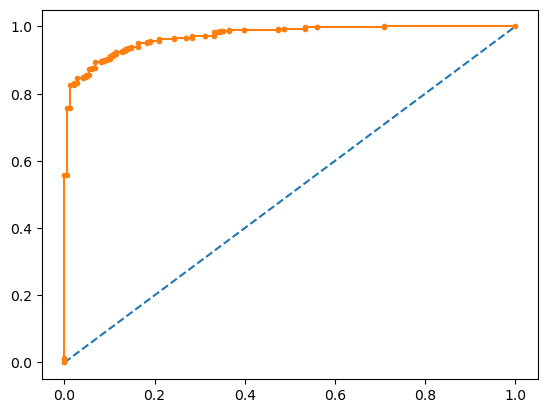

In [5]:
from sklearn.metrics import roc_curve
#from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

# predecir probabilidades
probs = logreg_model.predict_proba(X_test)
probs = probs[:, 1]

# calcular curva de roc
fpr, tpr, thresholds = roc_curve(y_test, probs)
pyplot.plot([0, 1], [0, 1], linestyle='--')
pyplot.plot(fpr, tpr, marker='.')
pyplot.show()


## 2. Evaluación del predictor de titulares de noticias motivadoras de comentarios ##

Se evaluarán dos métodos, que son:
<ol>
<li>Entrenar el sistema con los valores de tf.idf de los términos de los titulares</li>
<li>Entrenar el sistema con los valores de tf.idf de los términos que tienen un valor de polaridad</li>
</ol>

A partir de ahora, llamaremos al primer método, <i>Método T</i> y al segundo método <i>Método P</i>.

### 2.1 Clasificación con el método T ###

In [6]:
#Importación de los módulos y métodos

import pandas as pd

#Importar el módulo que carga un fichero con documentos vectorizados
import pickle

#Importar métodos para realizar la clasificación y su evaluación
from sklearn.model_selection import train_test_split 
from sklearn import metrics

### Preprocesado

In [7]:
#Ponemos los datos del fichero csv en un dataframe
df = pd.read_csv('NYT-Comment-Headlines.csv', sep='\t')

#La clase de cada titular está ya declarada en la columna 'Tag', en la que el titular está etiquetado como 'TOP' 
#o 'NOTOP'. Podemos, por tanto, hacer el tag labelling. Para ello se crean dos listas:
#data: lista que recoge los titulares
#data_labels: lista de las etiquetas de los titulares, en el mismo orden en el que están los titulares en 'data'

data = []
data_labels = []

headlines = df['Headline'].tolist()
tags = df['Tag'].tolist()

for i in range(len(headlines)): 
    data.append(headlines[i]) 
    data_labels.append(tags[i])
    
#Tomamos la matriz con los vectores que representan los titulares según el valor de tf.idf de sus términos 
#lematizados.
#Los vectores ya se calcularon en el notebook PLA-1, por lo que cargamos el fichero con la matriz que los contiene

MNYT = pickle.load(open('NYT-TOPHEADLINES-TFIDFMODEL.pk', "rb"))

print(MNYT)


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


### Preparación del corpus de entrenamiento y test

In [8]:
X_train, X_test, y_train, y_test  = train_test_split(
        MNYT, 
        data_labels,     # Etiquetas de los datos
        train_size=0.80, # Se dedica el 80% del corpus total al corpus de entrenamiento
        random_state=1234)


### Entrenamiento y test del clasificador SVC

In [9]:
from sklearn.svm import LinearSVC

classifier = LinearSVC()
#Entrenamiento
svm_model = classifier.fit(X=X_train, y=y_train)
#Clasificación
y_pred = svm_model.predict(X_test)

print(y_pred)


['NONTOP' 'NONTOP' 'NONTOP' 'NONTOP' 'NONTOP' 'NONTOP' 'NONTOP' 'NONTOP'
 'NONTOP' 'TOP' 'TOP' 'NONTOP' 'NONTOP' 'NONTOP' 'TOP' 'TOP' 'NONTOP'
 'NONTOP' 'NONTOP' 'NONTOP' 'NONTOP' 'NONTOP' 'NONTOP' 'NONTOP' 'NONTOP'
 'NONTOP' 'NONTOP' 'NONTOP' 'NONTOP' 'NONTOP' 'TOP' 'NONTOP' 'NONTOP'
 'NONTOP' 'NONTOP' 'NONTOP' 'NONTOP' 'NONTOP' 'NONTOP' 'NONTOP' 'NONTOP'
 'NONTOP' 'NONTOP' 'NONTOP' 'NONTOP' 'NONTOP' 'NONTOP' 'NONTOP' 'NONTOP'
 'NONTOP' 'NONTOP' 'NONTOP' 'TOP' 'NONTOP' 'TOP' 'NONTOP' 'TOP' 'NONTOP'
 'NONTOP' 'NONTOP' 'NONTOP' 'NONTOP' 'NONTOP' 'NONTOP' 'NONTOP' 'NONTOP'
 'NONTOP' 'NONTOP' 'NONTOP' 'NONTOP' 'NONTOP' 'NONTOP' 'NONTOP' 'NONTOP'
 'TOP' 'NONTOP' 'TOP' 'NONTOP' 'NONTOP' 'NONTOP' 'NONTOP' 'NONTOP'
 'NONTOP' 'NONTOP' 'NONTOP' 'NONTOP' 'NONTOP' 'NONTOP' 'NONTOP' 'NONTOP'
 'NONTOP' 'NONTOP' 'NONTOP' 'NONTOP' 'NONTOP' 'TOP' 'NONTOP' 'NONTOP'
 'NONTOP' 'NONTOP' 'NONTOP' 'NONTOP' 'NONTOP' 'NONTOP' 'NONTOP' 'TOP'
 'NONTOP' 'NONTOP' 'NONTOP' 'NONTOP' 'TOP' 'NONTOP' 'NONTOP' 'NONTOP'

/Users/alex/anaconda3/envs/env_ML/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


### Entrenamiento y clasificación con un clasificador basado en <i>logistic regression</i>

In [10]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression()
#Entrenamiento
log_model = classifier.fit(X=X_train, y=y_train)
#Clasificación
y_pred = log_model.predict(X_test)

#Se calculan las métricas de evaluación
lm = metrics.classification_report(y_test, y_pred, labels=list(set(data_labels)))

print(lm)


              precision    recall  f1-score   support

         TOP       0.64      0.08      0.15        85
      NONTOP       0.71      0.98      0.82       192

    accuracy                           0.70       277
   macro avg       0.67      0.53      0.48       277
weighted avg       0.69      0.70      0.61       277



### Entrenamiento y clasificación con un clasificador bayesiano

In [11]:
from sklearn.naive_bayes import MultinomialNB

classifier = MultinomialNB()
#Entrenamiento
bayes_model = classifier.fit(X=X_train, y=y_train)
#Clasificación
y_pred = bayes_model.predict(X_test)

#Se calculan las métricas de evaluación
bm = metrics.classification_report(y_test, y_pred, labels=data_labels)

print(bm)


              precision    recall  f1-score   support

      NONTOP       0.70      0.98      0.81       192
      NONTOP       0.70      0.98      0.81       192
         TOP       0.43      0.04      0.07        85
      NONTOP       0.70      0.98      0.81       192
         TOP       0.43      0.04      0.07        85
      NONTOP       0.70      0.98      0.81       192
      NONTOP       0.70      0.98      0.81       192
      NONTOP       0.70      0.98      0.81       192
      NONTOP       0.70      0.98      0.81       192
      NONTOP       0.70      0.98      0.81       192
      NONTOP       0.70      0.98      0.81       192
      NONTOP       0.70      0.98      0.81       192
      NONTOP       0.70      0.98      0.81       192
      NONTOP       0.70      0.98      0.81       192
      NONTOP       0.70      0.98      0.81       192
         TOP       0.43      0.04      0.07        85
      NONTOP       0.70      0.98      0.81       192
      NONTOP       0.70    

### Entrenamiento y clasificación con un clasificador SVM

In [12]:
import sklearn.svm

classifier = sklearn.svm.LinearSVC()
#Entrenamiento
svm_model = classifier.fit(X=X_train, y=y_train)
#Clasificación
y_pred = svm_model.predict(X_test)

#Se calculan las métricas de evaluación
svm = metrics.classification_report(y_test, y_pred, labels=data_labels)

print(svm)


              precision    recall  f1-score   support

      NONTOP       0.73      0.92      0.82       192
      NONTOP       0.73      0.92      0.82       192
         TOP       0.57      0.24      0.33        85
      NONTOP       0.73      0.92      0.82       192
         TOP       0.57      0.24      0.33        85
      NONTOP       0.73      0.92      0.82       192
      NONTOP       0.73      0.92      0.82       192
      NONTOP       0.73      0.92      0.82       192
      NONTOP       0.73      0.92      0.82       192
      NONTOP       0.73      0.92      0.82       192
      NONTOP       0.73      0.92      0.82       192
      NONTOP       0.73      0.92      0.82       192
      NONTOP       0.73      0.92      0.82       192
      NONTOP       0.73      0.92      0.82       192
      NONTOP       0.73      0.92      0.82       192
         TOP       0.57      0.24      0.33        85
      NONTOP       0.73      0.92      0.82       192
      NONTOP       0.73    

/Users/alex/anaconda3/envs/env_ML/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


### Entrenamiento y clasificación con un clasificador Random Forest

In [13]:
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier(n_estimators=10)
#Entrenamiento
rf_model = classifier.fit(X=X_train, y=y_train)
#Clasificación
y_pred = rf_model.predict(X_test)

#Se calculan las métricas de evaluación
rm = metrics.classification_report(y_test, y_pred, labels=data_labels)

print(rm)


              precision    recall  f1-score   support

      NONTOP       0.73      0.94      0.82       192
      NONTOP       0.73      0.94      0.82       192
         TOP       0.63      0.22      0.33        85
      NONTOP       0.73      0.94      0.82       192
         TOP       0.63      0.22      0.33        85
      NONTOP       0.73      0.94      0.82       192
      NONTOP       0.73      0.94      0.82       192
      NONTOP       0.73      0.94      0.82       192
      NONTOP       0.73      0.94      0.82       192
      NONTOP       0.73      0.94      0.82       192
      NONTOP       0.73      0.94      0.82       192
      NONTOP       0.73      0.94      0.82       192
      NONTOP       0.73      0.94      0.82       192
      NONTOP       0.73      0.94      0.82       192
      NONTOP       0.73      0.94      0.82       192
         TOP       0.63      0.22      0.33        85
      NONTOP       0.73      0.94      0.82       192
      NONTOP       0.73    

### 2.2 Clasificación con el método P ###

### Importación de los módulos y métodos

In [14]:
import pandas as pd

#Importar la librería NLTK
import nltk
#Importar tokenizador del paquete NLTK
from nltk import word_tokenize

#Importar la librería con los métodos para hacer la vectorización
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

#Importar métodos para realizar la clasificación y su evaluación
from sklearn.model_selection import train_test_split 
from sklearn import metrics


### Preparación

In [15]:
import re

#Se crea un diccionario (sentword) según el cual las palabras de AFINN tienen un valor numérico que
#indica una polaridad. Los valores negativos indican una polaridad negativa, y los valores positivos una polaridad
#positiva
sentword = {}
sentdicfile = 'AFINN-111.txt'

with open(sentdicfile, 'r') as snf:
    senlines = snf.readlines()
    for sl in senlines:
        sl = sl.strip().split('\t')
        sentword[sl[0]] = int(sl[1])
        
#El preprocesado según el método P consiste en transformar cada titular en una lista con los tokens del
#titular que tienen una polaridad. Esto es, los tokens del titular que están en AFINN.
#No hace falta lematizar el token puesto que AFINN recoge las palabras en todas sus formas.

def transform_sent_text(text):
    sent_stream = []
    tokens = word_tokenize(text.lower())
    stripped_tokens = [tk.strip('".,;:-():!?-‘’ ') for tk in tokens]
    for st in stripped_tokens:
        if re.match("^[a-z]+.*",st):
            if st in sentword:
                sent_stream.append(st)
            else:
                sent_stream.append('')
    return " ".join(sent_stream)

data_transformed2 = [transform_sent_text(d) for d in data]

#Vectorización de los titulares transformados
NYTP2_vectorizer = TfidfVectorizer(analyzer= 'word')

#Se crea la nueva matriz
NYTP2= NYTP2_vectorizer.fit_transform(data_transformed2)
MNYP2 = NYTP2.toarray()

#Creamos una matriz (Mmerged2) que es la unión de la matriz con la vectorización de los titulares según el metodo T 
#(MNYT) con la matriz que representa la vectorización de los titulares según el método P (MNYP2)
Mmerged2 = np.append(MNYT, MNYP2, axis=1)


### Preparación del corpus de entrenamiento y test

In [16]:
X_train, X_test, y_train, y_test  = train_test_split(
        Mmerged2, 
        data_labels,     # Etiquetas de los datos
        train_size=0.80, # Se dedica el 80% del corpus total al corpus de entrenamiento
        random_state=1234)


### Entrenamiento y clasificación con un clasificador basado en <i>logistic regression</i>

In [17]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression()
##Entrenamiento
log_model = classifier.fit(X=X_train, y=y_train)
#Clasificación
y_pred = log_model.predict(X_test)

#Se calculan las métricas de evaluación
lm = metrics.classification_report(y_test, y_pred, labels=data_labels)

print(lm)


              precision    recall  f1-score   support

      NONTOP       0.71      0.98      0.83       192
      NONTOP       0.71      0.98      0.83       192
         TOP       0.73      0.09      0.17        85
      NONTOP       0.71      0.98      0.83       192
         TOP       0.73      0.09      0.17        85
      NONTOP       0.71      0.98      0.83       192
      NONTOP       0.71      0.98      0.83       192
      NONTOP       0.71      0.98      0.83       192
      NONTOP       0.71      0.98      0.83       192
      NONTOP       0.71      0.98      0.83       192
      NONTOP       0.71      0.98      0.83       192
      NONTOP       0.71      0.98      0.83       192
      NONTOP       0.71      0.98      0.83       192
      NONTOP       0.71      0.98      0.83       192
      NONTOP       0.71      0.98      0.83       192
         TOP       0.73      0.09      0.17        85
      NONTOP       0.71      0.98      0.83       192
      NONTOP       0.71    

### Entrenamiento y clasificación con un clasificador bayesiano

In [18]:
from sklearn.naive_bayes import MultinomialNB

classifier = MultinomialNB()
##Entrenamiento
bayes_model = classifier.fit(X=X_train, y=y_train)
#Clasificación
y_pred = bayes_model.predict(X_test)

#Se calculan las métricas de evaluación
bm = metrics.classification_report(y_test, y_pred, labels=data_labels)

print(bm)


              precision    recall  f1-score   support

      NONTOP       0.72      0.98      0.83       192
      NONTOP       0.72      0.98      0.83       192
         TOP       0.77      0.12      0.20        85
      NONTOP       0.72      0.98      0.83       192
         TOP       0.77      0.12      0.20        85
      NONTOP       0.72      0.98      0.83       192
      NONTOP       0.72      0.98      0.83       192
      NONTOP       0.72      0.98      0.83       192
      NONTOP       0.72      0.98      0.83       192
      NONTOP       0.72      0.98      0.83       192
      NONTOP       0.72      0.98      0.83       192
      NONTOP       0.72      0.98      0.83       192
      NONTOP       0.72      0.98      0.83       192
      NONTOP       0.72      0.98      0.83       192
      NONTOP       0.72      0.98      0.83       192
         TOP       0.77      0.12      0.20        85
      NONTOP       0.72      0.98      0.83       192
      NONTOP       0.72    

### Entrenamiento y clasificación con un clasificador SVM

In [19]:
import sklearn.svm

classifier = sklearn.svm.LinearSVC()
##Entrenamiento
svm_model = classifier.fit(X=X_train, y=y_train)

#Clasificación
y_pred = svm_model.predict(X_test)

#Se calculan las métricas de evaluación
svm = metrics.classification_report(y_test, y_pred, labels=data_labels)

print(svm)


              precision    recall  f1-score   support

      NONTOP       0.73      0.93      0.81       192
      NONTOP       0.73      0.93      0.81       192
         TOP       0.56      0.21      0.31        85
      NONTOP       0.73      0.93      0.81       192
         TOP       0.56      0.21      0.31        85
      NONTOP       0.73      0.93      0.81       192
      NONTOP       0.73      0.93      0.81       192
      NONTOP       0.73      0.93      0.81       192
      NONTOP       0.73      0.93      0.81       192
      NONTOP       0.73      0.93      0.81       192
      NONTOP       0.73      0.93      0.81       192
      NONTOP       0.73      0.93      0.81       192
      NONTOP       0.73      0.93      0.81       192
      NONTOP       0.73      0.93      0.81       192
      NONTOP       0.73      0.93      0.81       192
         TOP       0.56      0.21      0.31        85
      NONTOP       0.73      0.93      0.81       192
      NONTOP       0.73    

/Users/alex/anaconda3/envs/env_ML/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


### Entrenamiento y clasificación con un clasificador Random Forest

In [20]:
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier(n_estimators=10)
##Entrenamiento
rf_model = classifier.fit(X=X_train, y=y_train)
#Clasificación
y_pred = rf_model.predict(X_test)

#Se calculan las métricas de evaluación
rm = metrics.classification_report(y_test, y_pred, labels=data_labels)

print(rm)

              precision    recall  f1-score   support

      NONTOP       0.74      0.93      0.82       192
      NONTOP       0.74      0.93      0.82       192
         TOP       0.62      0.25      0.35        85
      NONTOP       0.74      0.93      0.82       192
         TOP       0.62      0.25      0.35        85
      NONTOP       0.74      0.93      0.82       192
      NONTOP       0.74      0.93      0.82       192
      NONTOP       0.74      0.93      0.82       192
      NONTOP       0.74      0.93      0.82       192
      NONTOP       0.74      0.93      0.82       192
      NONTOP       0.74      0.93      0.82       192
      NONTOP       0.74      0.93      0.82       192
      NONTOP       0.74      0.93      0.82       192
      NONTOP       0.74      0.93      0.82       192
      NONTOP       0.74      0.93      0.82       192
         TOP       0.62      0.25      0.35        85
      NONTOP       0.74      0.93      0.82       192
      NONTOP       0.74    

## 3. Evaluación del clasificador de noticias falsas ##

### Importación de los módulos y métodos

In [21]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn import metrics
import pandas as pd
import numpy as np
import scipy as sp


### Preparación

In [22]:
df = pd.read_csv('OPINIONS-TAGGED-FAKE.csv', sep='\t')

data = []
data_labels = []

opinions = df['OPINION'].tolist()
tags = df['TAG'].tolist()

for i in range(len(opinions)): 
    data.append(opinions[i]) 
    data_labels.append(tags[i])
    
#Vectorización
tfidfvectorizer = TfidfVectorizer(analyzer= text_process)

X = tfidfvectorizer.fit_transform(data)
M2 = X.toarray()

#Preparación de los corpus de entrenamiento y test
X_train, X_test, y_train, y_test  = train_test_split(
        M2, 
        data_labels,
        train_size=0.80, 
        random_state=1234)


### Entrenamiento y clasificación con un clasificador basado en <i>logistic regression</i>

In [23]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression()
##Entrenamiento
log_model = classifier.fit(X=X_train, y=y_train)
#Clasificación
y_pred = log_model.predict(X_test)

#Se calculan las métricas de evaluación
lm = metrics.classification_report(y_test, y_pred, labels=data_labels)

print(lm)


              precision    recall  f1-score   support

     FAKENEG       0.79      0.82      0.80        85
     FAKENEG       0.79      0.82      0.80        85
     FAKENEG       0.79      0.82      0.80        85
     FAKENEG       0.79      0.82      0.80        85
     FAKENEG       0.79      0.82      0.80        85
     FAKENEG       0.79      0.82      0.80        85
     FAKENEG       0.79      0.82      0.80        85
     FAKENEG       0.79      0.82      0.80        85
     FAKENEG       0.79      0.82      0.80        85
     FAKENEG       0.79      0.82      0.80        85
     FAKENEG       0.79      0.82      0.80        85
     FAKENEG       0.79      0.82      0.80        85
     FAKENEG       0.79      0.82      0.80        85
     FAKENEG       0.79      0.82      0.80        85
     FAKENEG       0.79      0.82      0.80        85
     FAKENEG       0.79      0.82      0.80        85
     FAKENEG       0.79      0.82      0.80        85
     FAKENEG       0.79    

### Entrenamiento y clasificación con un clasificador Multinomial Naïve Bayes

In [24]:
from sklearn.naive_bayes import MultinomialNB

classifier = MultinomialNB()
#Entrenamiento
bayes_model = classifier.fit(X=X_train, y=y_train)
#Clasificación
y_pred = bayes_model.predict(X_test)

#Se calculan las métricas de evaluación
bm = metrics.classification_report(y_test, y_pred, labels=data_labels)

print(bm)


              precision    recall  f1-score   support

     FAKENEG       0.69      0.93      0.79        85
     FAKENEG       0.69      0.93      0.79        85
     FAKENEG       0.69      0.93      0.79        85
     FAKENEG       0.69      0.93      0.79        85
     FAKENEG       0.69      0.93      0.79        85
     FAKENEG       0.69      0.93      0.79        85
     FAKENEG       0.69      0.93      0.79        85
     FAKENEG       0.69      0.93      0.79        85
     FAKENEG       0.69      0.93      0.79        85
     FAKENEG       0.69      0.93      0.79        85
     FAKENEG       0.69      0.93      0.79        85
     FAKENEG       0.69      0.93      0.79        85
     FAKENEG       0.69      0.93      0.79        85
     FAKENEG       0.69      0.93      0.79        85
     FAKENEG       0.69      0.93      0.79        85
     FAKENEG       0.69      0.93      0.79        85
     FAKENEG       0.69      0.93      0.79        85
     FAKENEG       0.69    

### Entrenamiento y clasificación con un clasificador linear SVC

In [25]:
import sklearn.svm

classifier = sklearn.svm.LinearSVC()
#Entrenamiento
svm_model = classifier.fit(X=X_train, y=y_train)
#Clasificación
y_pred = svm_model.predict(X_test)

svm = metrics.classification_report(y_test, y_pred, labels=data_labels)

print(svm)


/Users/alex/anaconda3/envs/env_ML/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


              precision    recall  f1-score   support

     FAKENEG       0.78      0.84      0.81        85
     FAKENEG       0.78      0.84      0.81        85
     FAKENEG       0.78      0.84      0.81        85
     FAKENEG       0.78      0.84      0.81        85
     FAKENEG       0.78      0.84      0.81        85
     FAKENEG       0.78      0.84      0.81        85
     FAKENEG       0.78      0.84      0.81        85
     FAKENEG       0.78      0.84      0.81        85
     FAKENEG       0.78      0.84      0.81        85
     FAKENEG       0.78      0.84      0.81        85
     FAKENEG       0.78      0.84      0.81        85
     FAKENEG       0.78      0.84      0.81        85
     FAKENEG       0.78      0.84      0.81        85
     FAKENEG       0.78      0.84      0.81        85
     FAKENEG       0.78      0.84      0.81        85
     FAKENEG       0.78      0.84      0.81        85
     FAKENEG       0.78      0.84      0.81        85
     FAKENEG       0.78    

### Entrenamiento y clasificación con un clasificador Random Forest

In [26]:
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier(n_estimators=10)
#Entrenamiento
rf_model = classifier.fit(X=X_train, y=y_train)
#Clasificación
y_pred = rf_model.predict(X_test)

#Se calculan las métricas de evaluación
rm = metrics.classification_report(y_test, y_pred, labels=data_labels)

print(rm)


              precision    recall  f1-score   support

     FAKENEG       0.53      0.61      0.57        85
     FAKENEG       0.53      0.61      0.57        85
     FAKENEG       0.53      0.61      0.57        85
     FAKENEG       0.53      0.61      0.57        85
     FAKENEG       0.53      0.61      0.57        85
     FAKENEG       0.53      0.61      0.57        85
     FAKENEG       0.53      0.61      0.57        85
     FAKENEG       0.53      0.61      0.57        85
     FAKENEG       0.53      0.61      0.57        85
     FAKENEG       0.53      0.61      0.57        85
     FAKENEG       0.53      0.61      0.57        85
     FAKENEG       0.53      0.61      0.57        85
     FAKENEG       0.53      0.61      0.57        85
     FAKENEG       0.53      0.61      0.57        85
     FAKENEG       0.53      0.61      0.57        85
     FAKENEG       0.53      0.61      0.57        85
     FAKENEG       0.53      0.61      0.57        85
     FAKENEG       0.53    